#import libraries

In [ ]:
!pip install focal_loss

In [ ]:
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import drive
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc, confusion_matrix
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# Layers to be used for building our model
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPool2D, GlobalMaxPooling2D,Flatten,Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from keras.applications.densenet import DenseNet169
from focal_loss import BinaryFocalLoss
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

#load train dataset for humerus

In [ ]:
#defining base path
base_path = "/content/drive/My Drive/Project/MURA-v1.1"
#construct the file path to the CSV file named "train_image_paths.csv" by joining the base_path and the CSV file's name using the os.path.join
train_image_csv_path = os.path.join(base_path, "train_image_paths.csv")
#will read the above csv file and save in the data frame with column name paths
train_images_df = pd.read_csv(train_image_csv_path, names=['paths'])
#create complete file paths for each X-ray image.
train_images_df["paths"] = "/content/drive/My Drive/Project/" + train_images_df["paths"]
#create new column label in the dataframe  will indicate +ve or -ve
# If a path contains the word 'positive,' it is assigned a label of 1 (abnormal), and if not, it's assigned a label of 0 (normal).
train_images_df['label'] = train_images_df['paths'].str.contains('positive').astype(int)
# It extracts the seventh element (index 7) of each path after splitting the path using '/'
train_images_df['body_part'] = train_images_df['paths'].str.split('/').str[7]
#  'label' column was initially created as integers (0 or 1), it is now converted to strings.
train_images_df['label'] = train_images_df['label'].astype(str)

In [ ]:
train_images_df['label_index']= train_images_df.body_part

In [ ]:
train_images_df.label_index.replace('XR_SHOULDER', 6, inplace=True)
train_images_df.label_index.replace('XR_HUMERUS', 5, inplace=True)
train_images_df.label_index.replace('XR_FINGER', 4, inplace=True)
train_images_df.label_index.replace('XR_ELBOW', 3, inplace=True)
train_images_df.label_index.replace('XR_WRIST', 2, inplace=True)
train_images_df.label_index.replace('XR_FOREARM', 1, inplace=True)
train_images_df.label_index.replace('XR_HAND', 0, inplace=True)

In [ ]:
train_images_df

,paths,label,body_part,label_index
0,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,6
1,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,6
2,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,6
3,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,6
4,/content/drive/My Drive/Project/MURA-v1.1/trai...,1,XR_SHOULDER,6
...,...,...,...,...
36803,/content/drive/My Drive/Project/MURA-v1.1/trai...,0,XR_HAND,0
36804,/content/drive/My Drive/Project/MURA-v1.1/trai...,0,XR_HAND,0
36805,/content/drive/My Drive/Project/MURA-v1.1/trai...,0,XR_HAND,0
36806,/content/drive/My Drive/Project/MURA-v1.1/trai...,0,XR_HAND,0


In [ ]:
train_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   paths        36808 non-null  object
 1   label        36808 non-null  object
 2   body_part    36808 non-null  object
 3   label_index  36808 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
train_images_df.shape

(36808, 4)

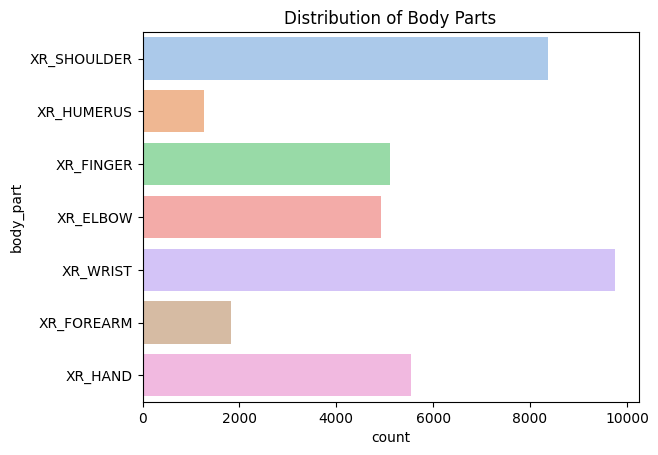

In [ ]:
sns.countplot(data= train_images_df, y='body_part' ,  palette="pastel")
plt.title('Distribution of Body Parts')
plt.show()

In [ ]:
train_images_df=train_images_df[train_images_df['body_part']=='XR_HUMERUS']

In [ ]:
train_images_df.head

<bound method NDFrame.head of                                                   paths label   body_part  \
8379  /content/drive/My Drive/Project/MURA-v1.1/trai...     1  XR_HUMERUS   
8380  /content/drive/My Drive/Project/MURA-v1.1/trai...     1  XR_HUMERUS   
8381  /content/drive/My Drive/Project/MURA-v1.1/trai...     1  XR_HUMERUS   
8382  /content/drive/My Drive/Project/MURA-v1.1/trai...     1  XR_HUMERUS   
8383  /content/drive/My Drive/Project/MURA-v1.1/trai...     1  XR_HUMERUS   
...                                                 ...   ...         ...   
9646  /content/drive/My Drive/Project/MURA-v1.1/trai...     0  XR_HUMERUS   
9647  /content/drive/My Drive/Project/MURA-v1.1/trai...     0  XR_HUMERUS   
9648  /content/drive/My Drive/Project/MURA-v1.1/trai...     0  XR_HUMERUS   
9649  /content/drive/My Drive/Project/MURA-v1.1/trai...     0  XR_HUMERUS   
9650  /content/drive/My Drive/Project/MURA-v1.1/trai...     0  XR_HUMERUS   

      label_index  
8379            5  
8380 

In [ ]:
train_images_df.shape

(1272, 4)

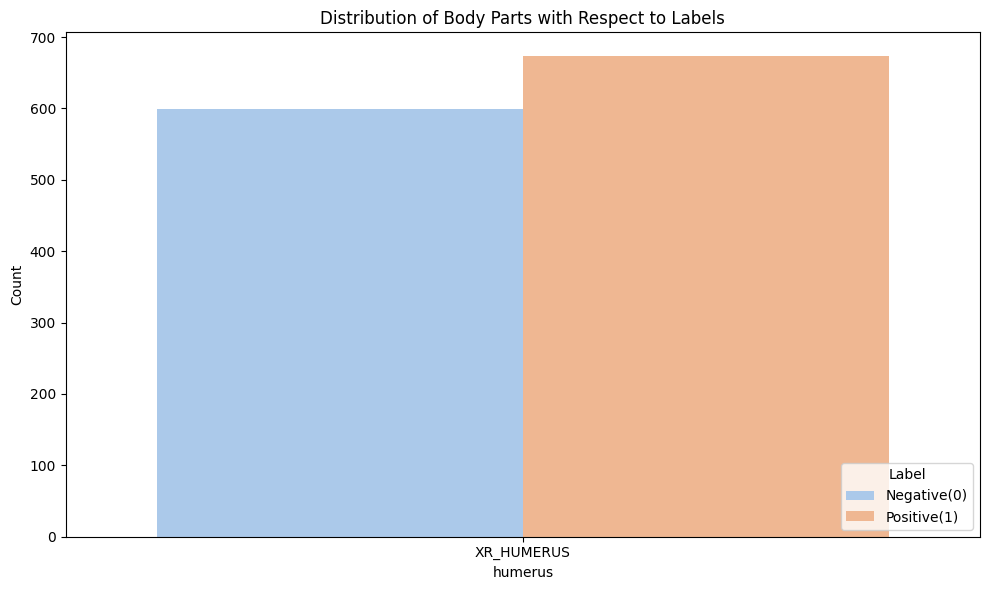

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data= train_images_df , x='body_part', hue='label' ,  palette="pastel")
plt.title('Distribution of Body Parts with Respect to Labels')
plt.xlabel('humerus')
plt.ylabel('Count')
plt.legend(title='Label', loc='lower right', labels=['Negative(0)', 'Positive(1)'])
plt.tight_layout()
plt.show()

#load test dataset for humerus

In [ ]:
#defining base path
base_path = "/content/drive/My Drive/Project/MURA-v1.1"
#construct the file path to the CSV file named "train_image_paths.csv" by joining the base_path and the CSV file's name using the os.path.join
test_image_csv_path = os.path.join(base_path, "valid_image_paths.csv")
#will read the above csv file and save in the data frame with column name paths
test_images_df = pd.read_csv(test_image_csv_path, names=['paths'])
#create complete file paths for each X-ray image.
test_images_df["paths"] = "/content/drive/My Drive/Project/" + test_images_df["paths"]
#create new column label in the dataframe  will indicate +ve or -ve
# If a path contains the word 'positive,' it is assigned a label of 1 (abnormal), and if not, it's assigned a label of 0 (normal).
test_images_df['label'] = test_images_df['paths'].str.contains('positive').astype(int)
# It extracts the seventh element (index 7) of each path after splitting the path using '/'
test_images_df['body_part'] = test_images_df['paths'].str.split('/').str[7]
#  'label' column was initially created as integers (0 or 1), it is now converted to strings.
test_images_df['label'] = test_images_df['label'].astype(str)

In [ ]:
test_images_df['label_index']= test_images_df.body_part

In [ ]:
test_images_df.label_index.replace('XR_SHOULDER', 6, inplace=True)
test_images_df.label_index.replace('XR_HUMERUS', 5, inplace=True)
test_images_df.label_index.replace('XR_FINGER', 4, inplace=True)
test_images_df.label_index.replace('XR_ELBOW', 3, inplace=True)
test_images_df.label_index.replace('XR_WRIST', 2, inplace=True)
test_images_df.label_index.replace('XR_FOREARM', 1, inplace=True)
test_images_df.label_index.replace('XR_HAND', 0, inplace=True)

In [ ]:
test_images_df

,paths,label,body_part,label_index
0,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_WRIST,2
1,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_WRIST,2
2,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_WRIST,2
3,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_WRIST,2
4,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_WRIST,2
...,...,...,...,...
3192,/content/drive/My Drive/Project/MURA-v1.1/vali...,0,XR_FINGER,4
3193,/content/drive/My Drive/Project/MURA-v1.1/vali...,0,XR_FINGER,4
3194,/content/drive/My Drive/Project/MURA-v1.1/vali...,0,XR_FINGER,4
3195,/content/drive/My Drive/Project/MURA-v1.1/vali...,0,XR_FINGER,4


In [ ]:
test_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   paths        3197 non-null   object
 1   label        3197 non-null   object
 2   body_part    3197 non-null   object
 3   label_index  3197 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 100.0+ KB


In [ ]:
test_images_df.shape

(3197, 4)

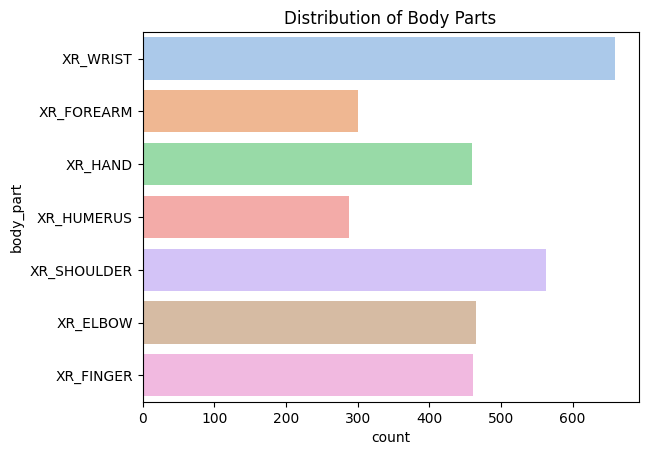

In [ ]:
sns.countplot(data= test_images_df, y='body_part' ,  palette="pastel")
plt.title('Distribution of Body Parts')
plt.show()

In [ ]:
test_images_df=test_images_df[test_images_df['body_part']=='XR_HUMERUS']

In [ ]:
test_images_df.head()

,paths,label,body_part,label_index
1420,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_HUMERUS,5
1421,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_HUMERUS,5
1422,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_HUMERUS,5
1423,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_HUMERUS,5
1424,/content/drive/My Drive/Project/MURA-v1.1/vali...,1,XR_HUMERUS,5


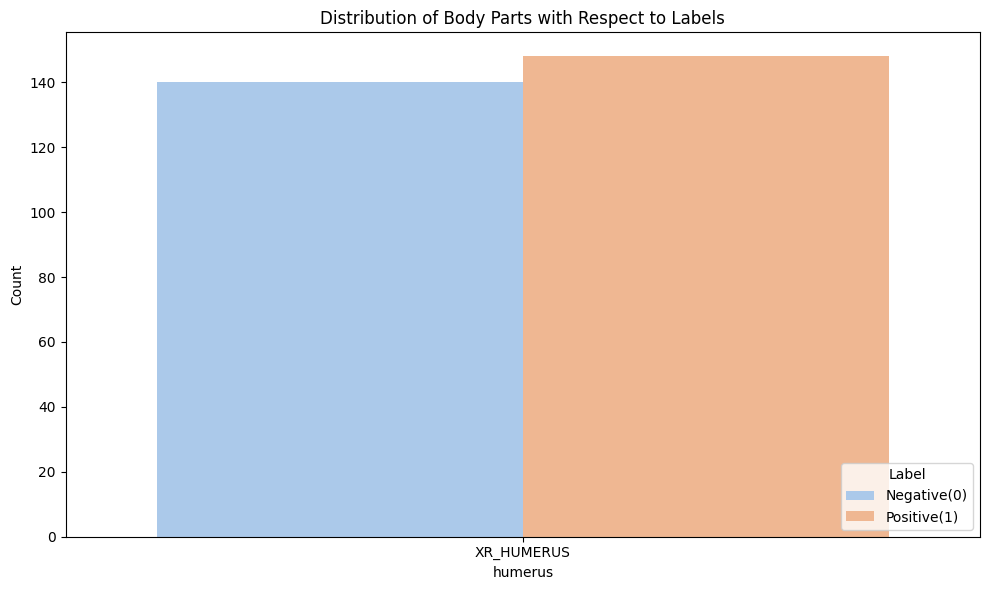

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data= test_images_df , x='body_part', hue='label' ,  palette="pastel")
plt.title('Distribution of Body Parts with Respect to Labels')
plt.xlabel('humerus')
plt.ylabel('Count')
plt.legend(title='Label', loc='lower right', labels=['Negative(0)', 'Positive(1)'])
plt.tight_layout()
plt.show()

In [ ]:
test_images_df.shape

(288, 4)

#Train-Test data preprocessing

In [ ]:
# Create an image data generator for validation
Image_Generator = ImageDataGenerator(rotation_range=30,horizontal_flip=True)


In [ ]:
#train data
train_generator = Image_Generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col="paths",
    y_col="label",
    target_size=(224, 224),  # Match the input size of your model
    color_mode='rgb',
    class_mode='binary',  # Use 'binary' since we have two classes
    batch_size=32,
    shuffle=True
)


Found 1272 validated image filenames belonging to 2 classes.


In [ ]:
#test data
test_generator = Image_Generator.flow_from_dataframe(
    dataframe=test_images_df,
    x_col="paths",
    y_col="label",
    target_size=(224, 224),  # Match the input size of your model
    color_mode='rgb',
    class_mode='binary',  # Use 'binary' since we have two classes
    batch_size=32,
    shuffle=False  # Keep it False to match predictions with filenames
)


Found 288 validated image filenames belonging to 2 classes.


#CNN model

In [ ]:
epochs = 100
batch_size = 32
input_shape = (224, 224, 1)

In [ ]:
def build_model():
    base_model = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    x = base_model.output

    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model
#Building a model
model = build_model()
model.compile(loss=BinaryFocalLoss(gamma = 2), optimizer='adam', metrics=['acc'])
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

In [ ]:
#train the module
model_history = model.fit(
    train_generator,
    epochs=epochs,
    workers=0,
    use_multiprocessing=False,
    steps_per_epoch = 39,
    validation_data=test_generator,
    validation_steps= 9,
    callbacks=callbacks_list
)


Epoch 1/100
39/39 [==============================] - 1338s 32s/step - loss: 0.2664 - acc: 0.5782 - val_loss: 7.8352 - val_acc: 0.5139 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 22s 555ms/step - loss: 0.1608 - acc: 0.6605 - val_loss: 7.7795 - val_acc: 0.5104 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 22s 552ms/step - loss: 0.1497 - acc: 0.6976 - val_loss: 1.8762 - val_acc: 0.5521 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 22s 553ms/step - loss: 0.1547 - acc: 0.7073 - val_loss: 0.8543 - val_acc: 0.5347 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - ETA: 0s - loss: 0.1475 - acc: 0.7073
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
39/39 [==============================] - 22s 551ms/step - loss: 0.1475 - acc: 0.7073 - val_loss: 3.4507 - val_acc: 0.4931 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 22s 557ms/step - loss: 0.1438 - acc: 0.7371 - val_loss: 0

#Model Evaluation and performance check

In [ ]:
label=['Normal', 'Abnormal']

In [ ]:
# Evaluate the models
model_eval = model.evaluate(test_generator)

9/9 [==============================] - 4s 440ms/step - loss: 0.1325 - acc: 0.7951


In [ ]:
print("model Evaluation:", '\n')
print("Loss:", model_eval[0], '\n')
print("Accuracy:", model_eval[1])

model Evaluation: 

Loss: 0.1325320601463318 

Accuracy: 0.7951388955116272


In [ ]:
# Make predictions on the test data
y_pred = model.predict(test_generator)
# Assuming y_pred contains probabilities of being 'abnormal'
# Applying a threshold of 0.5
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)


# Use the true labels from the test data generator
y_true = test_generator.labels

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

9/9 [==============================] - 6s 434ms/step


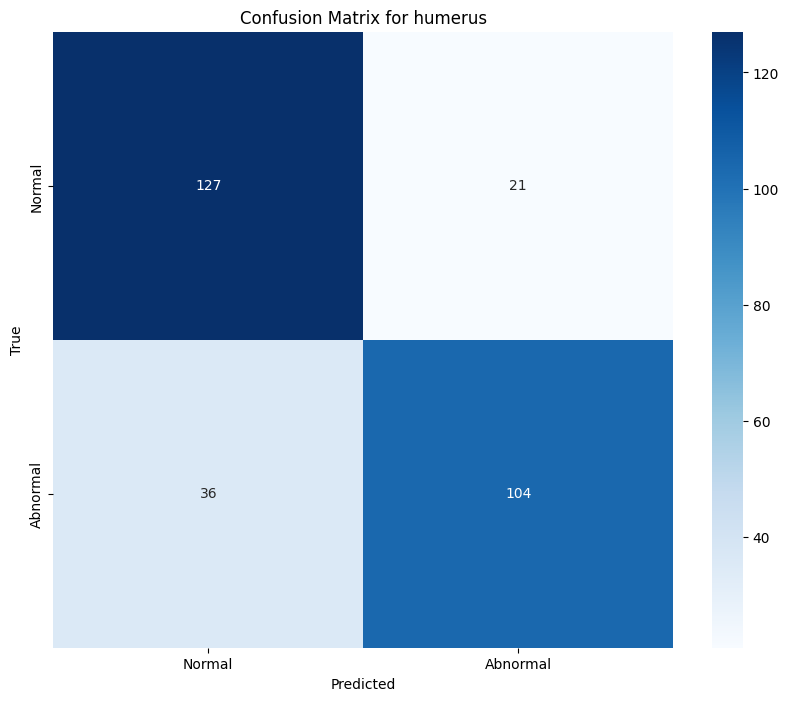

In [ ]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for humerus')
plt.show()

In [ ]:
# Print a classification report with additional metrics
class_report = classification_report(y_true, y_pred_classes, target_names=label)
print(class_report)

              precision    recall  f1-score   support

      Normal       0.78      0.86      0.82       148
    Abnormal       0.83      0.74      0.78       140

    accuracy                           0.80       288
   macro avg       0.81      0.80      0.80       288
weighted avg       0.80      0.80      0.80       288



#save model

In [ ]:
model.save('/content/drive/My Drive/Project/final_humreus_model_densnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
